In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torchvision.transforms as transforms
from Anchor.anchor import Anchor, Tasktype
from torchvision.models import inception_v3, resnet18
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

%load_ext autoreload
%autoreload 2

tensor([162])
tensor(162)
beagle 0.9371574521064758
tensor(166)
Walker hound 0.02404705062508583
tensor(167)
English foxhound 0.01230653002858162
tensor(161)
basset 0.002038035076111555
tensor(163)
bloodhound 0.0010032234713435173


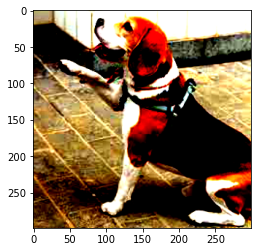

In [2]:

# model:c, h, w
# numpy, sklearn matplotlib: w, h, c
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# c, h, w

image = Image.open("../static/dog_paper.jpeg")
input = preprocess(image).unsqueeze(0)
# b, c, h, w

model = inception_v3(pretrained=True)
model.eval()

plt.imshow(input.squeeze().permute(1,2,0))
# h w c

with torch.no_grad():
    output = model(input)

print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)

with open("../static/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probs, 5)
    top5_prob, top5_catid = top5_prob.squeeze(), top5_catid.squeeze()
    for i in range(top5_prob.size(0)):
        print(top5_catid[i])
        print(categories[top5_catid[i]], top5_prob[i].item())

In [3]:
from Anchor.util import pytorch_image_wrapper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


explainer = Anchor(Tasktype.IMAGE)

@pytorch_image_wrapper(device)
def predict(x):
    return model(x)

method_paras = {"beam_size": 2, "desired_confidence": 1.0}
anchor = explainer.explain_instance(
    input.squeeze().permute(1,2,0),
    predict_fn=predict,
    method="beam",
    method_specific=method_paras,
    num_coverage_samples=1000,
)

INFO:root: Start Sampling
INFO:root: Start Beam Search


In [4]:
anchor

AnchorCandidate(feature_mask=[11, 19], precision=1.0, n_samples=144, positive_samples=144, coverage=0.246)

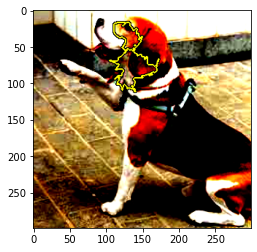

In [5]:

visu = explainer.visualize(anchor, input.squeeze().permute(1,2,0))
plt.imshow(visu)

In [ ]:
from torchvision import datasets

dataset = datasets.ImageFolder('../datasets/tiny_imagenet_train_sub/images', transform=preprocess)

[11, 8]
(87422, 2) (299, 299)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


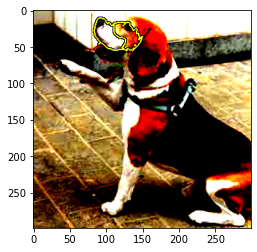

In [33]:
print(anchor.feature_mask)

idxs = np.argwhere(~np.isin(explainer.sampler.features,anchor.feature_mask))
print(idxs.shape, explainer.sampler.features.shape)
mask = explainer.sampler.features.copy()
mask[idxs[:, 0], idxs[:, 1]] = 0
# plt.imshow(input.squeeze().permute(2,1,0))
print(mask)
img = mark_boundaries(input.squeeze().permute(1,2,0), mask, mode="thick", outline_color=(0, 0, 0))
#img[idxs[:, 0], idxs[:, 1], :] = 0
plt.imshow(img)